# Is There a Seasonality in Number of Likes for Social Media Posts?

### Data Science Spring 2017, Olin College of Engineering, Report 2

This Jupyter notebook contains code used for analysis of social media posts posted by 15 top mainstream media outlets. Dataset used for this analysis is created by Patrick Martincheck, and can be obtained through [data.world](https://data.world/martinchek/2012-2016-facebook-posts).

Report that goes with this notebook can be found [here](https://github.com/SungwooPark/ThinkStats2/blob/master/reports/report2.md).

In [5]:
import thinkstats2
import pandas
import thinkplot
import numpy as np
import statsmodels.tsa.stattools as smtsa

%matplotlib inline

## Importing and structuring data

In [6]:
#dictionary of dataframes
dfs = {}

media_names = ["cnn","huff","la_times","npr","nbc","fox","fox_friends","cbs","bbc","abc","wsj","nyt","wash_post","time","usa_today"]

for name in media_names:
    dfs[name] = pandas.read_csv(name+"_mod.csv", encoding = "ISO-8859-1", quotechar='"',error_bad_lines=False, parse_dates = [19])

I created a dictionary of dataframs, in which a key is a name of media outlet and a value is a corresponding dataframe. Following is how the dataframe for each media outlet is structured.

In [7]:
dfs["huff"].tail(20)

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,shares_count,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,link,picture,posted_at
85369,"ï»¿""18468761129_10154392091781130""",18468761129,Timeline Photos,See you on the other side.,NaN,NaN,photo,added_photos,16797,504,868,2646,25,267,21,0,52,https://www.facebook.com/HuffingtonPost/photos...,https://scontent.xx.fbcdn.net/v/t1.0-0/p130x13...,2016-11-07 17:19:45
85370,"ï»¿""18468761129_10154392118616130""",18468761129,HuffPost Black Voices,NaN,Join HuffPost Black Voicesâ Jacques Morel Jr...,NaN,video,shared_story,100,19,0,2,1,0,5,0,0,https://www.facebook.com/blackvoicesdotcom/vid...,https://scontent.xx.fbcdn.net/v/t15.0-10/s130x...,2016-11-07 17:36:14
85371,"ï»¿""18468761129_10154392127876130""",18468761129,Why You Should Vote For Hillary If You're Agai...,'If your candidate focuses on maintaining and ...,I am a doctor who has dedicated her career to ...,huffingtonpost.com,link,shared_story,15197,490,3338,1176,17,82,8,0,39,http://huff.to/2fUmdQH,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 17:41:28
85372,"ï»¿""18468761129_10154392138876130""",18468761129,HuffPost Politics,NaN,Independent candidate Evan McMullin joins us i...,NaN,video,shared_story,147,72,0,6,11,4,2,0,20,https://www.facebook.com/HuffPostPolitics/vide...,https://scontent.xx.fbcdn.net/v/t15.0-10/s130x...,2016-11-07 17:46:40
85373,"ï»¿""18468761129_10154392168696130""",18468761129,"Thanks To Trump, I Blocked My Uncle On Faceboo...",'No longer do people just watch the evening ne...,My family seems to think God is a Republican.,huffingtonpost.com,link,shared_story,15417,1238,7656,308,258,2104,1740,0,107,http://huff.to/2fUiz9p,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 18:00:16
85374,"ï»¿""18468761129_10154392360686130""",18468761129,Ted Nugent Grabbing His Crotch During Trump Ra...,Donald J. Trump might be offended by JAY Z's l...,He made the gesture while on stage in Michigan.,huffingtonpost.com,link,shared_story,1970,2200,1127,87,353,1085,86,0,900,http://huff.to/2faeexz,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 19:00:15
85375,"ï»¿""18468761129_10154392533741130""",18468761129,"The Moment I Realized That Trump Triggers Men,...",'Iâm one of the countless women for whom Tru...,Of all the things Donald Trump has been called...,huffingtonpost.com,link,shared_story,826,136,157,18,22,18,193,0,109,http://huff.to/2ewI9fa,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 20:00:31
85376,"ï»¿""18468761129_10154392606781130""",18468761129,Baby Held By Larger Baby Is Ready For This Ele...,We are all this baby.,"Yeah, that about sums it up.",huffingtonpost.com,link,shared_story,4589,434,346,126,24,2983,12,0,26,http://huff.to/2ex3JR4,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 20:30:21
85377,"ï»¿""18468761129_10154392670856130""",18468761129,Glenn Beck Says He Supports Black Lives Matter...,Yes. Glenn Beck.,Hmm.,huffingtonpost.com,link,shared_story,19869,1578,4993,1004,4300,433,11,0,67,http://huff.to/2fhP51D,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 21:00:24
85378,"ï»¿""18468761129_10154392682811130""",18468761129,HuffPost Politics,NaN,"Election Day is just around the corner, so we'...",NaN,video,shared_story,56,41,0,6,1,0,0,0,2,https://www.facebook.com/HuffPostPolitics/vide...,https://scontent.xx.fbcdn.net/v/t15.0-10/s130x...,2016-11-07 21:05:35


From an original dataframe, I extract the information that I will be using for my analysis (number of likes and the timestamp) and create new dataframe that I will be working with. To convert the timestamp attribute, which is in date-year format, into numeric value that I can do arithmetic operations on, I created *years* attribute which is the timestamp represented as the number of years passed since the time first post was posted.

In [9]:
#Dataframe of likes and timestamp from the huffington post
huff_df = dfs['huff'][['likes_count', 'posted_at']]
#Add year column which is timestamp represented as a number of years
#since the first post
start = huff_df.posted_at[0]
one_year = np.timedelta64(1, 'Y')
huff_df['years'] = (huff_df.posted_at - start) / one_year

/home/sung/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Following scatter plot shows the numbers of likes that posts from the Huffington Posts received. There are few posts that received more than 100,000 likes but including those values makes the scatter plot hard to interpret, so I set the range of y-axis to be 0 to 100,000, which covers most of the data points.

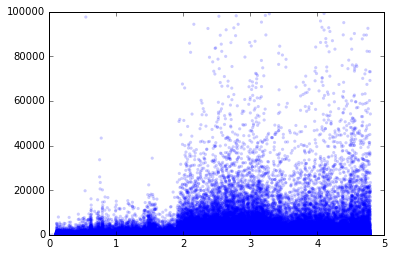

In [12]:
thinkplot.Config(xlim=[0,5], ylim=[0,100000])
thinkplot.Scatter(huff_df.years, huff_df.likes_count, s=10)

I applied the sasme operation (extraction of relevant data and conversion of timestamp) to ABC dataframe and got following scatter plot.

In [13]:
#Dataframe of likes and timestamp from the abc
abc_df = dfs['abc'][['likes_count', 'posted_at']]
#Add year column which is timestamp represented as a number of years
#since the first post
start = abc_df.posted_at[0]
one_year = np.timedelta64(1, 'Y')
abc_df['years'] = (abc_df.posted_at - start) / one_year

/home/sung/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


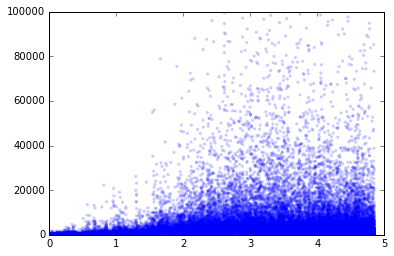

In [17]:
thinkplot.Config(xlim=[0,5],ylim=[0,100000])
thinkplot.Scatter(abc_df.years, abc_df.likes_count, s=10)

## Investigating Seasonality

To investigate the seasonality, I have to extract the trend from the dataset. To compute the trend, I calculated rolling averages.

In [19]:
#Rolling averages
#huff_df_roll_mean = pandas.rolling_mean(huff_df.likes_count, 30)
huff_df_roll_mean = huff_df.likes_count.rolling(center=False, window=30).mean()

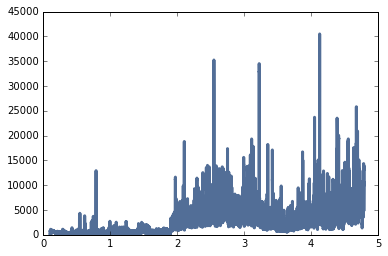

In [20]:
thinkplot.Plot(huff_df.years,huff_df_roll_mean)

Exponentially weighted moving averages takes care of missing values better than a simple rolling mean. Following is the graph of EWMA for the Huffington Post dataset.

In [21]:
#EWMA (exponentially-weighted moving average)
#huff_ewma = pandas.ewma(huff_df.likes_count, span=30)
huff_ewma = huff_df.likes_count.ewm(ignore_na=False,min_periods=0,span=30,adjust=True).mean()

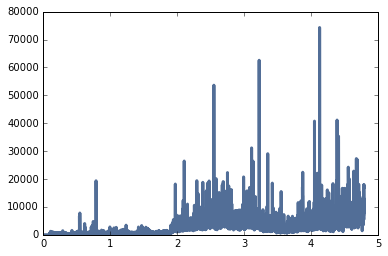

In [22]:
thinkplot.Plot(huff_df.years,huff_ewma)

To accurate compute the seasonality in the data, we have to subtract the trend from the data. In order to do this, I subtracted EWMA values of number of likes from the original number of likes. Resulting data are residuals.

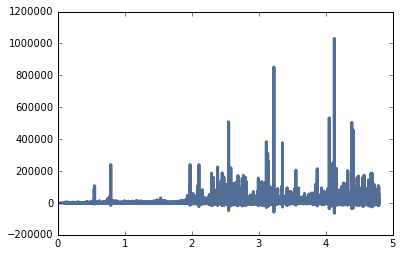

In [28]:
#Subtracting away trend
huff_resid = huff_df.likes_count - huff_ewma
thinkplot.Plot(huff_df.years, huff_resid)

I compute autocorrelation function on the residuals, which will give serial correlation values for a range of lags (a number of days for this case). 

In [31]:
#autocorrelation function
huff_acf = smtsa.acf(huff_resid, nlags=365, unbiased=True)

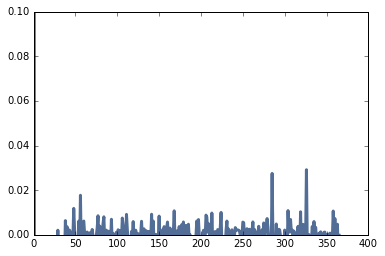

In [34]:
thinkplot.Config(ylim=[0,0.1])
thinkplot.Plot(np.arange(366),huff_acf)

All serial correlation values are extremely small.

In [35]:
huff_acf[1], huff_acf[7], huff_acf[30], huff_acf[365]

(-0.014442282792503917,
 -0.026183919462200732,
 -0.0079701924205183051,
 -0.00019594467253888708)

Serial correlation values that indicate daily, weekly, monthly, and yearly seasonality are extremely small, indicating there is no seasonlity in the data.

Following code applies the operations shown above on other dataframes and computes serial correlation values.

In [25]:
#Run autocorrelate function analysis on multiple media outlets

acf_values = []

for name in media_names:
    df = dfs[name][['likes_count', 'posted_at']]
    
    start = df.posted_at[0]
    one_year = np.timedelta64(1, 'Y')
    df['years'] = (df.posted_at - start) / one_year
    
    df_ewma = df.likes_count.ewm(ignore_na=False,min_periods=0,span=30,adjust=True).mean()
    
    df_resid = df.likes_count - df_ewma
    #df_resid[df_resid>100000] = np.NaN
    
    acf_values.extend([abs(df_acf[1]), abs(df_acf[7]), abs(df_acf[30]), abs(df_acf[365])])
    
    df_acf = smtsa.acf(df_resid, nlags=365, unbiased=True)
    print("{:10}: 1 days:{}   7 days:{}   30 days:{}   365 days:{}".format(name, df_acf[1], df_acf[7], df_acf[30], df_acf[365]))
    
acf_values.sort()
print("5 biggest acf values: ", acf_values[-5:])

/home/sung/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cnn       : 1 days:-0.029756534977066724   7 days:-0.0004785693401439372   30 days:-0.0006886404933035297   365 days:-0.002546237951539804
huff      : 1 days:-0.014442282792503917   7 days:-0.026183919462200732   30 days:-0.007970192420518305   365 days:-0.00019594467253888708
la_times  : 1 days:-0.031138879018477013   7 days:-0.008998078485048548   30 days:-0.0042169043615362225   365 days:-0.003682419291510698
npr       : 1 days:-0.027428518881018975   7 days:-0.025808008785235252   30 days:-0.006584060781139451   365 days:-0.006376719346369967
nbc       : 1 days:-0.019437874239638102   7 days:-0.028276027511564595   30 days:-0.006532568617991822   365 days:0.005096078582649778
fox       : 1 days:-0.004308856610576095   7 days:-0.008457467641435866   30 days:-0.0007433323062722195   365 days:-0.012392345085506525
fox_friends: 1 days:-0.004017589133827942   7 days:-0.0315307119193414   30 days:-0.002057091266958815   365 days:0.0059177877708477
cbs       : 1 days:-0.03166688187731559 